In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from tqdm.auto import tqdm


def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(islice(it, n))
        if not chunk:
            return
        yield chunk

In [2]:
# Check differences between two was of calculating values. 
from trajectory.gsolver import accel_acd, accel_xt

rows = []
for v_0, v_c, v_1 in tqdm(list(product(velocities,velocities, velocities))):
    x_ad, t_ad = accel_acd(v_0, v_c, v_1, a_max)
    
    x_a, t_a = accel_xt(v_0, v_c, a_max)
    x_d, t_d = accel_xt(v_c, v_1, a_max)
    
    rows.append( dict(x = x_ad - (x_a+x_d), t = t_ad -(t_a+t_d) ))
    
df = pd.DataFrame(rows)
                
df.describe()
    

  0%|          | 0/13824 [00:00<?, ?it/s]

,x,t
count,1.382400e+04,1.382400e+04
mean,-4.584248e-16,-5.398423e-19
std,1.117347e-14,6.388327e-18
min,-5.684342e-14,-2.775558e-17
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.136868e-13,2.775558e-17


<AxesSubplot:xlabel='x'>

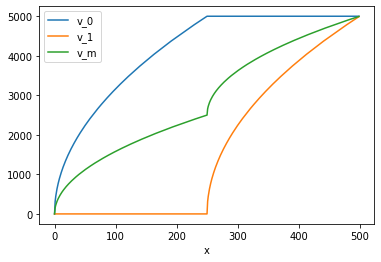

In [3]:
# Boundary Value reduction
from trajectory.gsolver import set_bv
j = Joint(5_000, 50_000)
rows = []
for x in range(500):
    v_0, v_1 = set_bv(x, v_max, v_max, a_max)
    rows.append(dict(x=x,v_0=v_0, v_1=v_1, v_m=(v_0+v_1)/2))

df = pd.DataFrame(rows)
df.set_index('x').plot()

In [4]:
# Test that values get passed through the Block sontructors. 
from trajectory.planner import  Joint

j = Joint(5_000, 50_000)
self = j.new_block(100,123,456)

assert self.x == 100, self.x
assert self.v_0 == 123
assert self.joint.v_max == 5_000

self = j.new_block(100,123,456)

assert self.x == 100
assert self.v_0 == 123
assert self.joint.v_max == 5_000


In [5]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList
from trajectory.gsolver import consistantize

# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            self = j.new_block(x, v_0, v_1).init()
            assert abs(self.area-self.x) < 1, (self, i)
            t = self.t*tf
            self.plan(t)
            assert abs(self.area - self.x)<3, (self.area, self, i, self.flag)
            if self.t != t:
                ot = self.t
                self.plan(ot)
                #assert round(self.t, 6) == round(ot, 6), (self.t, t)
                
            x_c, x_e = consistantize(self, True)
            a = self.area
        except:
            errors.append( (i, tf, self))
            raise
        d = dict(i=i, x=x, t=self.t, v_0=self.v_0, v_1=self.v_1, v_c=self.v_c, x_e = x_e, a=a, qc=self.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)  
print('# rows =', len(df))
df.qc.value_counts(normalize=True)

ImportError: cannot import name 'consistantize' from 'trajectory.gsolver' (/Users/eric/Documents/proj/trajectory/trajectory/gsolver.py)

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList
from trajectory.gsolver import consistantize

# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i in tqdm(list(range(10_000))):

  
    x =   int(random() < .90)*randint(-10000,10000)
    v_0 = int(random() < .90)*randint(0, j.v_max)
    v_1 = int(random() < .90)*randint(0,j.v_max)
                
    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        a = x_e = None
        try:
            self = j.new_block(x, v_0, v_1).init()
            assert abs(self.area-self.x) < 1, (self, i)
            t = self.t*tf
            self.plan(t)
            assert abs(self.area - self.x)<3, (self.area, self, i, self.flag)
            if self.t != t:
                ot = self.t
                self.plan(ot)
                #assert round(self.t, 6) == round(ot, 6), (self.t, t)
                
            x_c, x_e = consistantize(self, True)
            a = self.area
        except:
            errors.append( (i, x, v_0, v_1, tf))
            raise
        
        d = dict(i=i, x=x, t=self.t, v_0=self.v_0, v_1=self.v_1, v_c=self.v_c, x_e = x_e, a=a, qc=self.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)  
print('# rows =', len(df), "# errors = ", len(errors) )
df.qc.value_counts(normalize=True)

In [ ]:
if errors:
    (i, x, v_0, v_1, tf)  = errors[0]
    print(i, x, v_0, v_1)
    self = j.new_block(x, v_0, v_1).init()
    t = self.t*tf
    try:
        self.plan(t)
    except:
        print(t, self.x, self.t, self.v_0, self.v_1, tf)

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 
from tqdm.auto import tqdm
from trajectory.planner import Joint, SegmentList
from trajectory.gsolver import consistantize

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    try:
        self = j.new_block(x, v_0, v_1).init()
        t = self.t
    
        for tf in np.linspace(1.01, 3, num=10):
            self.plan(t * tf)
            self.plan_ramp(t*tf)
    except:
        errors.append( (i,  (x, v_0, v_1), tf) )
        raise
        

In [ ]:
if errors:
    (i,  (x, v_0, v_1), tf) = errors[0]
    print(x, v_0, v_1, tf)
    
    #(x, v_0, v_1, tf) =  10,250,750,1.231111111111111


    self = j.new_block(x, v_0, v_1).init()
    t = self.t

    self.plan(t * tf)
    self.plan_ramp(t*tf)
    
           
    self.plan(t * tf)
    self.plan_ramp(t*tf)
    
    print(self)

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)   
s = sl.move([1000,1])
s = sl.move([1,1000])
s = sl.move([1000,1])
s = sl.move([1,1000])
s = sl.move([1000,1])
s = sl.move([1,1000])

print(len(list(sl.discontinuities())))

sl.plot()


In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*1

sl = SegmentList(joints)   
s = sl.move([1000])
s = sl.move([-500])
s = sl.move([1000])
s = sl.move([500])

sl.plot()

In [ ]:
%reload_ext autoreload
%autoreload 2

# Serious discontinuities. 
from trajectory import * 

j = Joint(5_000, 50_000)
joints = [j]*4
sl = SegmentList(joints)   
sl.move([160, 669, 991, 0])
sl.move([163, 529, 414, 369])
sl.move([-494, 733, 914, 0])
sl.move([-133, 0, 0, -596])
sl.move([-383, 606, 35, -955])
sl.move([-528, 583, 0, -868])
sl.move([-11, 0, 710, -524])
sl.move([-924, 658, 957, -940])
sl.move([-379, 110, 771, -275])

sl.plot()

In [ ]:
%%time 
from trajectory.planner import Joint, SegmentList
from trajectory.plot import *
from random import random, randint
from tqdm.auto import tqdm
j = Joint(5_000, 50_000)
n = 4
joints = [j]*n
signs = [1]*n

sl = SegmentList(joints)   


def rand_move(axis):

    z = int(random() < .9) # Make 10% of the moves zero
    if random() < .1: # change direction 10% of the time
        signs[axis] = -signs[axis]

    return z * signs[axis] * randint(240,5000)
 
move_sets = [ [ rand_move(axis) for axis in range(len(joints))] for _ in range(1000) ]

for move_n, moves in tqdm(list(enumerate(move_sets))):
    try:
        sl.move(moves)
    except:
        print("Move=", move_n, move_sets[move_n])
        raise
 
ds = list(sl.discontinuities())
if len(ds):
    print(f"Got {len(ds)} discontinuities") 
    for a, self in sl.discontinuities():
        print(a.id, 'diff=',abs(a.v_1-self.v_0), a.v_1,'!=',self.v_0 )

#df = sl.dataframe
#df = df[df.axis==0]
#sl.plot()

In [ ]:
pd.Series([ s.replans for s in sl.segments]).describe()

In [ ]:
# Search for discontinuities
from trajectory.planner import Joint, SegmentList
from trajectory.plot import *
from random import random, randint
from tqdm.auto import tqdm

j = Joint(5_000, 50_000)
n = 4
joints = [j]*n
signs = [1]*n

def f():
    for i in tqdm(list(range(100))):
        sl = SegmentList(joints)  
        move_sets = [ [ rand_move(axis) for axis in range(len(joints))] for _ in range(5) ]


        for move_n, moves in enumerate(move_sets):
            try:
                sl.move(moves)
            except:
                print("Move=", move_n, move_sets[move_n])
                return move_sets

        if len(list(sl.discontinuities())):
            ds = list(sl.discontinuities())
            print(len(ds), move_sets)   
            sl.plot()
            return move_sets
    else:
        print("Got Nothing")

move_sets = f()
print(move_sets)